# K-nearest neighbors: wine quality classification

## Notebook set-up

In [1]:
import os
from itertools import combinations
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import functions as funcs

RANDOM_SEED = 315
CLASS_WEIGHT = 'balanced'
CROSS_VAL_FOLDS = 7

## 1. Data loading
### 1.1. Load data from URL

In [2]:
url = 'https://raw.githubusercontent.com/rosinni/k-nearest-neighbors-project-tutorial/refs/heads/main/winequality-red.csv'
data_df = pd.read_csv(url, sep=';')

### 1.2. Save a local copy

In [3]:
# 1.2 Save a local copy
data_df.to_csv("k_nearest_neighbors_data.csv", index=False)



### 1.3. Inspect

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## 2. EDA

### 2.1. Data composition

#### 2.1.1. Label frequencies

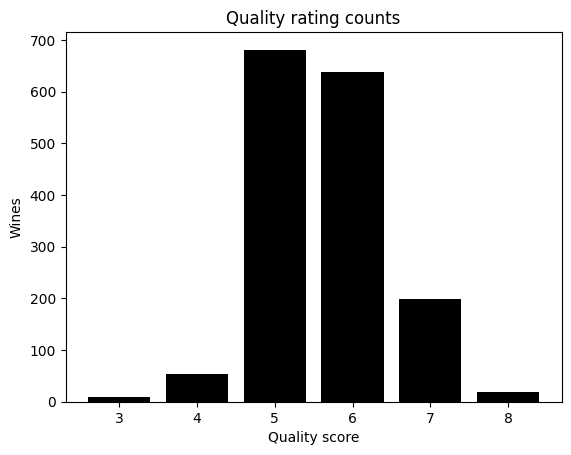

In [13]:

quality_counts = data_df['quality'].value_counts()

plt.title('Quality rating counts')
plt.bar(quality_counts.index, quality_counts.values, color='black')
plt.xlabel('Quality score')
plt.ylabel('Wines')
plt.show()


#### 2.1.2. Feature distributions

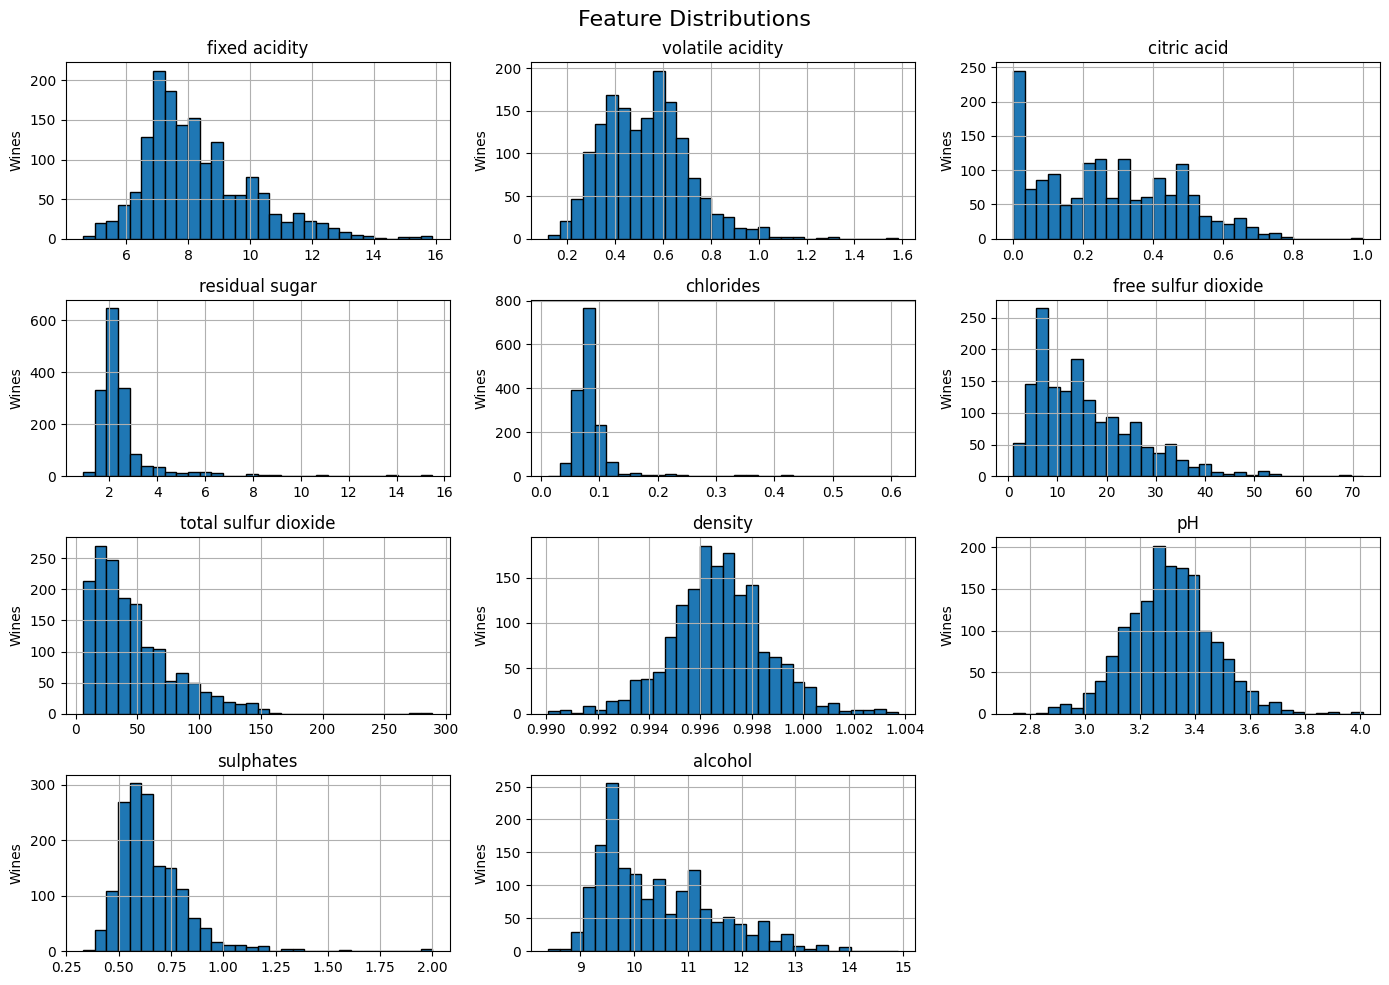

In [ ]:
# Finding out how each feature is distributed individually, helps in identifying outliers. 
# Plot distributions of all numeric columns

features = ['fixed acidity', 'volatile acidity', 'citric acid',
            'residual sugar', 'chlorides', 'free sulfur dioxide',
            'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

# Create histograms for all features and capture axes
axes = data_df[features].hist(figsize=(14, 10), bins=30, edgecolor='black')

# Set y-axis label for each subplot
for ax in axes.flatten():
    ax.set_ylabel('Wines')

# Overall title and layout
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout()
plt.show()


### 2.2. Feature interactions

#### 2.2.1. Feature cross-correlations

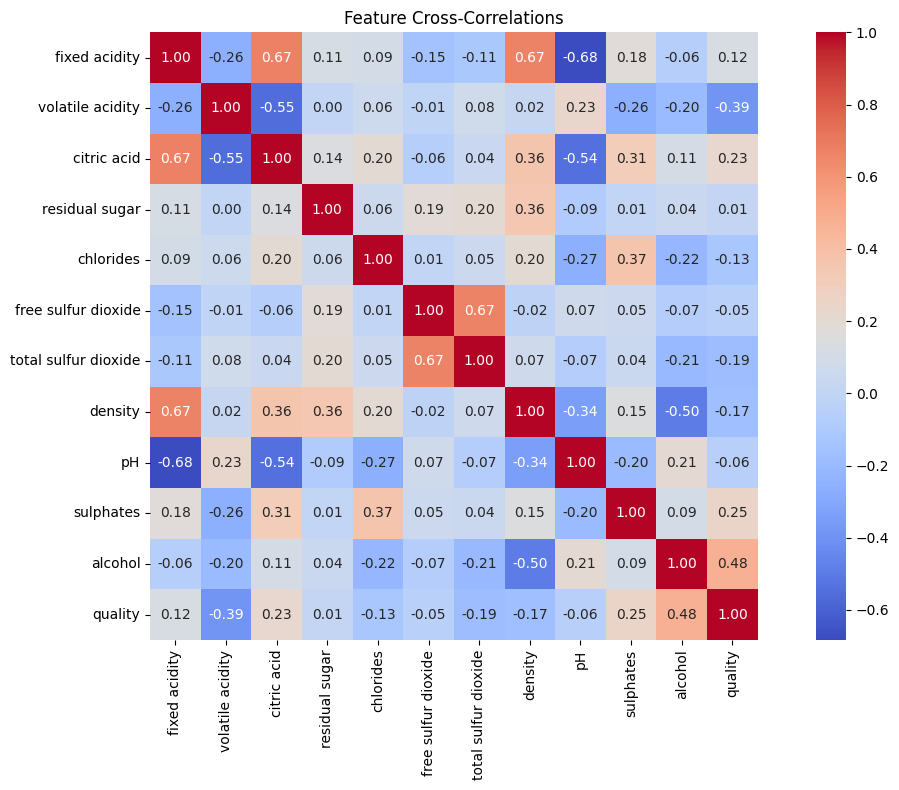

In [ ]:
# Find correlations between each feature. 

# Compute correlation matrix
corr_matrix = data_df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Feature Cross-Correlations')
plt.tight_layout()
plt.show()

#### 2.2.2. Feature-label interactions

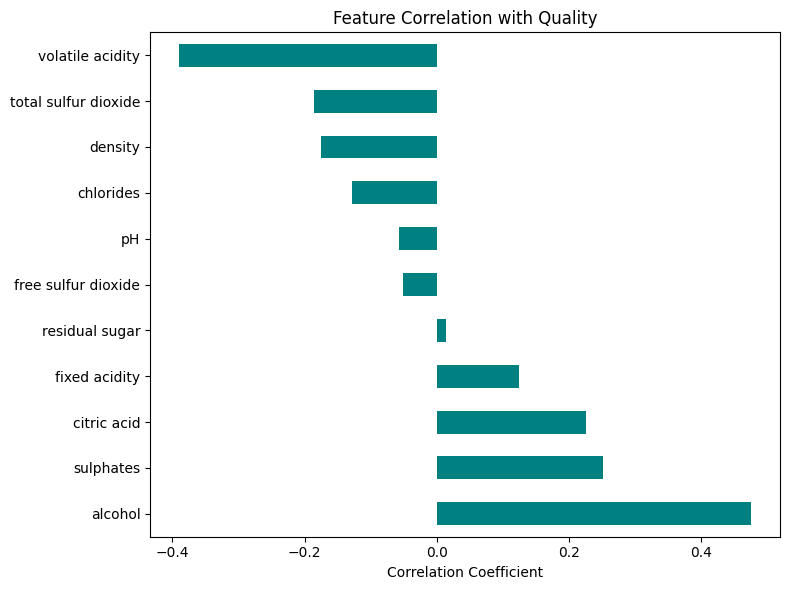

In [ ]:
# This chart shows how each feature contributes to wine quality.

# Calculate correlations with the target variable
target_corr = data_df.corr(numeric_only=True)['quality'].sort_values(ascending=False)

# Plot bar chart of feature-label correlations
target_corr.drop('quality').plot(kind='barh', figsize=(8, 6), color='teal')
plt.title('Feature Correlation with Quality')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


## 3. Data preparation

### 3.1. Label binning

In [29]:
# Your code here...
# Convert quality scores to binary: good (>=7) or not
data_df['quality_label'] = data_df['quality'].apply(lambda q: 1 if q >= 7 else 0)
data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
 12  quality_label         1599 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 162.5 KB


### 3.2. Train-test split

In [ ]:
# Split the data into a training sample and a test sample. Once it gets a good training accuracy percentage with the training sample I will introduce it to a brand new sample to see how it performs.

# Features (drop original and binned quality labels)
X = data_df.drop(['quality', 'quality_label'], axis=1)
y = data_df['quality_label']

# Stratified split to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


### 3.3. Scaling

In [23]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data, transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 3. KNN modeling

In [24]:
cross_val_scores = {
    'Model': [],
    'Score': []
}

### 3.1. Baseline logistic regression model

In [25]:
# Create a baseline model so that I can gauge how well the new model does. The baseline is the bare minimum performance. 

# Baseline logistic regression
log_reg = LogisticRegression(class_weight='balanced', random_state=42)

# Perform cross-validation
log_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=7, scoring='accuracy')

# Record results
cross_val_scores['Model'].append('Logistic Regression')
cross_val_scores['Score'].append(log_scores.mean())

print(f"Logistic Regression Accuracy (CV mean): {log_scores.mean():.4f}")

Logistic Regression Accuracy (CV mean): 0.7764


### 3.2. Naive KNN classifier

In [26]:
# Naive KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Perform cross-validation
knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=7, scoring='accuracy')

# Record results
cross_val_scores['Model'].append('KNN (k=5)')
cross_val_scores['Score'].append(knn_scores.mean())

print(f"KNN Accuracy (CV mean): {knn_scores.mean():.4f}")

KNN Accuracy (CV mean): 0.8577


### 3.3. Optimized KNN

In [27]:
# Set up the KNN and parameter grid
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Run GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='accuracy',
    cv=7,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Best model results
best_knn = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

# Record results
cross_val_scores['Model'].append(f"Optimized KNN")
cross_val_scores['Score'].append(best_score)

print("Best KNN parameters:", best_params)
print(f"Optimized KNN Accuracy (CV mean): {best_score:.4f}")

Best KNN parameters: {'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'distance'}
Optimized KNN Accuracy (CV mean): 0.9015


### 3.4. Cross-validation of optimized model

In [30]:
# Cross-validate the best model obtained from GridSearchCV
optimized_knn_scores = cross_val_score(best_knn, X_train_scaled, y_train, cv=7, scoring='accuracy')

# Output the results
print(f"Optimized KNN CV Mean Accuracy: {optimized_knn_scores.mean():.4f}")
print(f"Fold Scores: {optimized_knn_scores}")

# Optionally log to results dictionary (if not done earlier)
cross_val_scores['Model'].append('Optimized KNN CV')
cross_val_scores['Score'].append(optimized_knn_scores.mean())

Optimized KNN CV Mean Accuracy: 0.9015
Fold Scores: [0.92349727 0.89617486 0.90710383 0.89617486 0.8852459  0.9010989
 0.9010989 ]


## 4. Model comparison

/tmp/ipykernel_15926/19684060.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=boxplot_df, x='Model', y='Score', palette='Set3')


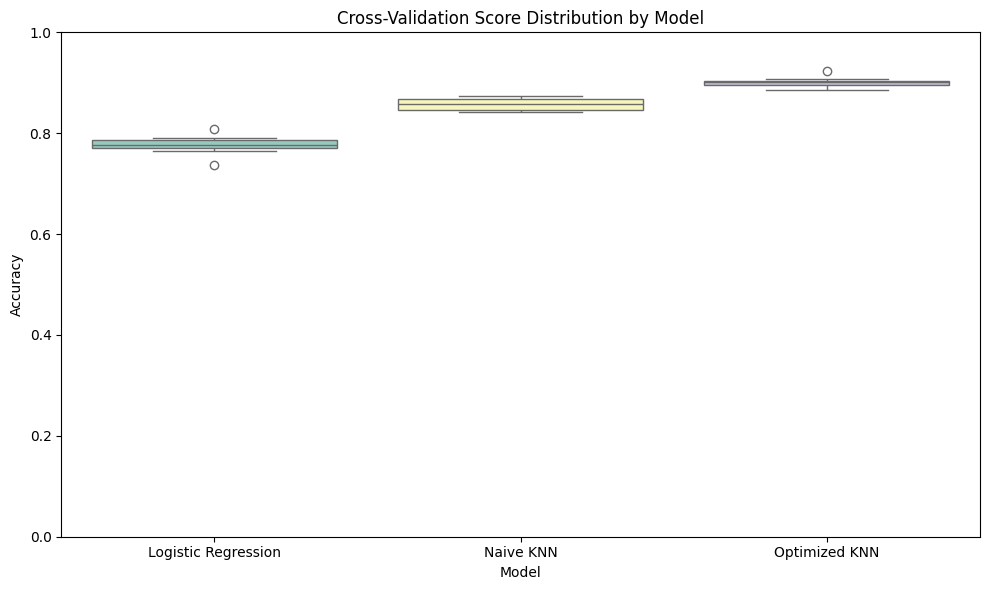

In [38]:

# Assuming you kept all per-fold results in variables
cv_results = {
    'Logistic Regression': cross_val_score(LogisticRegression(class_weight='balanced', random_state=42), X_train_scaled, y_train, cv=7),
    'Naive KNN': cross_val_score(KNeighborsClassifier(n_neighbors=5), X_train_scaled, y_train, cv=7),
    'Optimized KNN': optimized_knn_scores,
}

# Flatten dictionary into a DataFrame
boxplot_df = pd.DataFrame([
    {'Model': model, 'Score': score}
    for model, scores in cv_results.items()
    for score in scores
])


plt.figure(figsize=(10, 6))
sns.boxplot(data=boxplot_df, x='Model', y='Score', palette='Set3')
plt.title('Cross-Validation Score Distribution by Model')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



## 5. Model evaluation

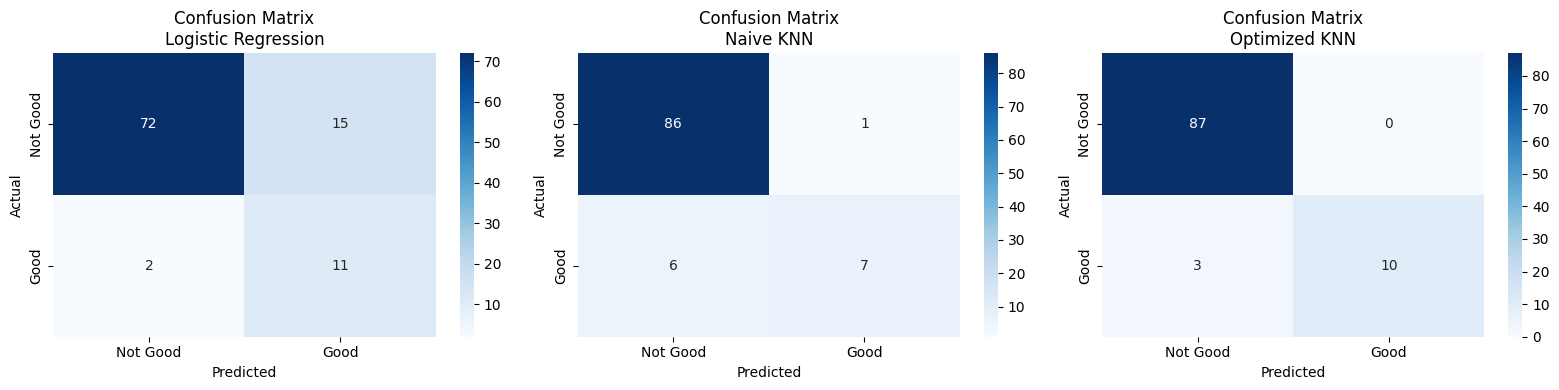

In [43]:

from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Subsample test set to 100 examples
X_test_sub = X_test_scaled[:100]
y_test_sub = y_test[:100]

# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Naive KNN": KNeighborsClassifier(n_neighbors=5),
    "Optimized KNN": best_knn  # from GridSearchCV
}

# Prepare figure
plt.figure(figsize=(16, 4))

# Loop through models and generate confusion matrices
for idx, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_sub)

    cm = confusion_matrix(y_test_sub, y_pred)

    plt.subplot(1, 3, idx)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Good', 'Good'],
                yticklabels=['Not Good', 'Good'])
    plt.title(f'Confusion Matrix\n{name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.ylim(2, 0)  # To fix heatmap display issue in matplotlib

plt.tight_layout()
plt.show()
